In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.cuda
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from scipy.linalg import svd
from tqdm import tqdm
from sklearn import tree
import seaborn as sns
import random
from ipywidgets import IntProgress

In [2]:
class Classifier_Net(nn.Module):
    def __init__(self, inputs):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.linear1 = nn.Linear(inputs, 256)
        self.linear2 = nn.Linear(256,512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256,1)
        
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.sigmoid(self.linear4(x))
        return x
    
    def save(self, file_name='model.pth', index=0):
        model_folder_path = './Classifier_models/model' 
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        complete_file_name = f"{index}_{file_name}"
        file_path = os.path.join(model_folder_path, complete_file_name)
        
        torch.save(self.state_dict(), file_path)
    
class Classifier_Trainer:
    def __init__(self, model, lr):
        self.lr = lr
        self.model = model
        self.device = model.device
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.BCEWithLogitsLoss()

    def train_step(self, state, outcome):
        state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)

        # Make a prediction
        pred = self.model(state)[0]

        self.optimizer.zero_grad()

        ## Calculate MSE loss on target and prediction
        loss = self.criterion(pred, outcome[0])
        loss.backward()

        self.optimizer.step()


## Agent tager filepath som input hvis man vil køre en model, der allerede er trænet.
class Agent:
    def __init__(self, X, y, file_path=None, training=True, device=None, 
                 learning_rate=0.01, model_name='testing', pcs=None):
        self.X = X
        self.y = y
        self.pcs = pcs
        self.LR = learning_rate
        if device is not None: ## Her kan man vælge at køre cpu selvom man har cuda
            self.device = device
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        inputs = len(self.X.T) + (len(self.pcs.T) if self.pcs is not None else 0)
        self.model = Classifier_Net(inputs=inputs).to(self.device) 
        self.model_name = model_name

        ## Definerer en masse variable baseret på __init__ input
        self.is_training = training
        self.file_path = file_path

        ## Hvis vi har en sti til en model, vil vi loade den i stedet for at træne en ny
        if self.file_path is not None:
            self.model.load_state_dict(torch.load(self.file_path, map_location=self.device))
            self.model.eval()

        ## Initialisér trainer
        self.trainer = Classifier_Trainer(self.model, lr=self.LR)

        ## Træner short memory

        ## Bestem en action
    def get_action(self, state):

        ## Laver state om til tensor og får en prediction fra modellen
        state_tensor = torch.tensor(state, dtype=torch.float).to(self.device).clone().detach()
        prediction = self.model(state_tensor)
        print(prediction.item())

        return torch.round(prediction).item()
    
    def train(self, rounds, evaluating=False, give_preds=False, index=None):
        accur = np.zeros(rounds)
        lower_acc = np.zeros(rounds)
        upper_acc = np.zeros(rounds)
        pos_accuracy = np.zeros(rounds)
        neg_accuracy = np.zeros(rounds)
        pos_outcome_tracker = []
        neg_outcome_tracker = []
        misclassified_obs = []
        decision_list = []
        global f
        
        for j in range(rounds):
            res = []
            decision_list = []
            raw_preds = []
            for i in range(len(self.X)):
                f.value += 1
                plt.plot(f.value)
                state = self.X[i]
                if self.pcs is not None:
                    pc_vals = [pc @ state for pc in self.pcs]
                    state = np.concatenate((state, pc_vals))
                outcome = self.y[i]
                outcome = torch.tensor([float(outcome)]).to(self.device)

                state_tensor = torch.tensor(state, dtype=torch.float).to(self.device).clone().detach()
                prediction = self.model(state_tensor)
                raw_preds.append(prediction.item())
                decision = torch.round(prediction).item()

                if give_preds:
                    decision_list.append(decision)
                reward = 1 if decision == outcome else 0

                if outcome.item() == 1:
                    ## Personen fik diabetes
                    if decision == 1: pos_outcome_tracker.append(1)
                    else: pos_outcome_tracker.append(0)
                else:
                    ## Personen fik ikke diabetes
                    if decision == 0: neg_outcome_tracker.append(1)
                    else: neg_outcome_tracker.append(0)

                if self.is_training: 
                    self.trainer.train_step(state, outcome)
                else: 
                    if reward == 0: misclassified_obs.append(self.X[i])

                res.append(reward)

            p_hat = np.mean(res)
            lower, upper =p_hat - 1.96*np.sqrt((p_hat*(1-p_hat))/len(res)), p_hat + 1.96*np.sqrt((p_hat*(1-p_hat))/len(res))
                
            accur[j] = np.mean(res)
            lower_acc[j], upper_acc[j] = lower, upper
        if self.is_training:
            self.model.save(index=index if index is not None else 'test')
        if give_preds: return decision_list, accur[-1], raw_preds
        
        if evaluating:
            pos_accuracy = np.mean(pos_outcome_tracker)
            neg_accuracy = np.mean(neg_outcome_tracker)
            return accur[0], lower_acc[0], upper_acc[0], pos_accuracy, neg_accuracy, misclassified_obs

        return np.concatenate(([accur], [lower_acc], [upper_acc]), axis=0)
    
    

In [3]:

def remove_nan(DataFrame):
    return DataFrame.copy().dropna()

def impute_nan(DataFrame, n=None):
    global n_nearest_neighbors
    imputer = KNNImputer(n_neighbors=(n if n is not None else n_nearest_neighbors))
    imputed_array = imputer.fit_transform(DataFrame)
    imputed_df = pd.DataFrame(data=imputed_array, columns=DataFrame.columns)
    return  imputed_df

def remove_outliers(DataFrame):
    # Calculate the mean and standard deviation for each column
    means = DataFrame.mean()
    stds = DataFrame.std()
    DataFrame = DataFrame.copy()

    global std_threshold

    # Create boolean DataFrame indicating whether or not observations exceed threshold
    conditions = (DataFrame < (means - std_threshold * stds)) | (DataFrame > (means + std_threshold * stds))

    # Any row that should be removed will have at least one True in the conditions DataFrame
    rows_to_remove = conditions.any(axis=1)

    # Remove the rows that meet the condition
    DataFrame = DataFrame[~rows_to_remove]
    return DataFrame

def remove_misclassified_observations(DataFrame):
    global features

    ## Prepare data for clustering
    k_df = remove_outliers(remove_nan(DataFrame))

    ## Instantialize the KMeans class and fit it on the data
    kmeans = KMeans(n_clusters=2, n_init=50, max_iter=10_000)
    kmeans.fit(k_df[features])

    ## Give the dataframe a column with the labels from the clusterer
    k_df = k_df.assign(cluster=kmeans.labels_)

    ## Map the outcome to a cluster
    mapping = k_df.groupby('cluster')['Outcome'].agg(lambda x: x.value_counts().index[0]).to_dict()
    k_df['cluster_mapped_to_class'] = k_df['cluster'].map(mapping)

    ## Create a boolean column, indicating whether or not the observation was misclassified
    k_df['misclassified'] = k_df['Outcome'] != k_df['cluster_mapped_to_class']
    misclassified_df = k_df[k_df['misclassified']]

    print('Accuracy of clusterer', round(100-len(misclassified_df)/len(k_df)*100,2),'%')

    ## Filter the dataframe for misclassified observations
    misclassified_indices = misclassified_df.index
    return DataFrame.copy().drop(misclassified_indices)

def get_cluster_df(DataFrame):
    global features

    df_copy = DataFrame.copy()
    cluster_list = np.full((len(df_copy),1), fill_value=-1)

    ## Prepare data for clustering
    k_df = remove_outliers(remove_nan(DataFrame))

    ## Instantialize the KMeans class and fit it on the data
    kmeans = KMeans(n_clusters=2, n_init=50, max_iter=10_000)
    kmeans.fit(k_df[features])

    ## Give the dataframe a column with the labels from the clusterer
    k_df = k_df.assign(cluster=kmeans.labels_)

    ## Map the outcome to a cluster
    mapping = k_df.groupby('cluster')['Outcome'].agg(lambda x: x.value_counts().index[0]).to_dict()
    k_df['cluster_mapped_to_class'] = k_df['cluster'].map(mapping)
    indices = k_df.index
    for idx in indices:
        cluster_list[idx] = k_df.loc[idx][len(k_df.columns)-1]
    df_copy = df_copy.assign(Cluster=cluster_list)
    return df_copy

def get_PCs(x):
    # Create an instance of the PCA class
    pca = PCA()

    # Apply PCA to the attributes
    principalComponents = pca.fit_transform(x)
    # Perform singular value decomposition
    Y = x - np.ones((x.shape[0], 1)) * x.mean(0)
    U, S, Vh = svd(Y, full_matrices=False)
    V = Vh.T
    return Vh




def k_split(k, DataFrame):
    global target_variable
    ## Shuffle the DataFrame
    shuffled = DataFrame.sample(frac=1)

    ## Split into k groups
    groups = np.array_split(shuffled, k)

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    pc_array = []

    for i in range(k):
        groups_copy = groups.copy()
        test_data = groups_copy.pop(i)

        training_frames = pd.concat(groups_copy)

        training_standard = training_frames.loc[:, features].values

        scaler = StandardScaler().fit(training_standard)

        ## Transofmr training data
        training_standard = scaler.transform(training_standard)

        X_train.append(training_standard)
        y_train.append(np.array(training_frames[target_variable]))

        test_standard = test_data.loc[:, features].values

        ## Standardize the test data according to the mean and std of training data
        test_standard = scaler.transform(test_standard)

        X_test.append(test_standard)
        y_test.append(np.array(test_data[target_variable]))

       ## Perform PCA
        Vh = get_PCs(training_standard)
        pc_array.append(Vh)
    return X_train, y_train, X_test, y_test, np.array(pc_array)

def cluster(X_train, y_train, X_test):
    'Returns (training data predictions, test data predictions)'
    global target_variable
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
    train_cluster_labels = kmeans.labels_
    df_train = pd.DataFrame({'Cluster': train_cluster_labels, 'Outcome_lab': y_train})
    cluster_positive_label = df_train.groupby('Cluster')['Outcome_lab'].mean().idxmax()
    cluster_col_train = np.array(df_train['Cluster'])
    train_cluster = cluster_col_train if cluster_positive_label else (cluster_col_train + 1) % 2

    test_cluster_labels = kmeans.predict(X_test)
    test_cluster_preds = (test_cluster_labels == cluster_positive_label).astype(int)

    # Return array of train clusters and array of prediction of clusters on test data
    return train_cluster, test_cluster_preds

def naive(X_train, y_train, X_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    x_pred = model.predict(X_train)
    return x_pred, y_pred

def dtree(X_train, y_train, X_test):
    d_tree = tree.DecisionTreeClassifier(criterion='gini')
    d_tree.fit(X_train, y_train)
    tree_pred = d_tree.predict(X_train)
    d_tree_test_pred = d_tree.predict(X_test)
    return tree_pred, d_tree_test_pred


In [4]:
# Read csv file to pd DataFrame
df = pd.read_csv('diabetes.csv')


## Data preparation
for col in df.columns:
    if col in ['Pregnancies', 'Outcome']:
        continue
    df[col] = df[col].replace(0, np.nan)

target_variable = 'Outcome'

drop_features = ['Insulin', 'SkinThickness']

drop_columns = np.concatenate(([target_variable], drop_features))

df = df.drop(columns=drop_features)

features = [col for col in df.columns if col not in [kol for kol in drop_columns]]

std_threshold = 4

df = remove_outliers(remove_nan(df))

k = 5


X_train, y_train, X_test, y_test, pc_array = k_split(k,df)

pcs_to_use = len(pc_array.T)

f = IntProgress(min=0, max=18621)
display(f)
%matplotlib
plt.figure
plt.ion()
plt.show()
clusters = []
naive_preds = []
tree_predics = []
for xtrain, ytrain, xtest in zip(X_train, y_train, X_test):
    clusters.append((cluster(xtrain, ytrain, xtest)))
    naive_preds.append(naive(xtrain,ytrain,xtest))
    tree_predics.append(dtree(xtrain,ytrain,xtest))

acc_c, compar_c = [], []
acc_n, compar_n = [], []
acc_t, compar_t = [], []
for i in range(len(y_test)):
        f.value += 1
        plt.plot(f.value, f.value)
        compar_c.append(np.column_stack((clusters[i][1], y_test[i])))
        compar_n.append(np.column_stack((naive_preds[i][1], y_test[i])))
        compar_t.append(np.column_stack((tree_predics[i][1], y_test[i])))
        if i != 0:
            compar_arr = np.concatenate((compar_arr, compar_c[i]))
            compar_n_arr = np.concatenate((compar_n_arr, compar_n[i]))
            compar_t_arr = np.concatenate((compar_t_arr, compar_t[i]))
        else: 
            compar_arr = compar_c[0]
            compar_n_arr = compar_n[0]
            compar_t_arr = compar_t[0]

for comp, comp_n, comp_t in zip(compar_arr,compar_n_arr, compar_t_arr):
    acc_c.append(1 if comp[0] == comp[1] else 0)
    acc_n.append(1 if comp_n[0] == comp_n[1] else 0)
    acc_t.append(1 if comp_t[0] == comp_t[1] else 0)
print('Cluster accuracy', np.mean(acc_c))
print('Naive accuracy', np.mean(acc_n))
print('Tree accuracy', np.mean(acc_t))

IntProgress(value=0, max=18621)

Using matplotlib backend: <object object at 0x000001A252594880>
Cluster accuracy 0.7011173184357542
Naive accuracy 0.755586592178771
Tree accuracy 0.6899441340782123


In [5]:
LR = 0.0001
rtt = 4
nn_acc = []
nn_train_pred_list = []
nn_test_pred_list = []
nn_train_round_pred_list = []

full_frames_train = []
full_frames_test = []

display(f)

for i in tqdm(range(len(y_test))):
    agent = Agent(X_train[i], y_train[i], learning_rate=LR)
    train_preds, train_acc, raw_train_preds = agent.train(rtt, give_preds=True, index=i)
    nn_train_pred_list.append(raw_train_preds)
    nn_train_round_pred_list.append(train_preds)

    agent = Agent(X_test[i], y_test[i], file_path=f'Classifier_models/model/{i}_model.pth',training=False)
    nn_preds, test_acc, raw_preds = agent.train(1, evaluating=True, give_preds=True)
    nn_acc.append(test_acc)
    nn_test_pred_list.append(raw_preds)

    print(f'Accuracy {i}: {round(test_acc*100,3)}%, (Train Accuracy {i}: {round(train_acc*100,3)}%)')
    full_frames_train.append(pd.DataFrame(np.column_stack((X_train[i], clusters[i][0], naive_preds[i][0], tree_predics[i][0],
                                                   raw_train_preds, y_train[i])), 
                                                    columns=np.concatenate((
                                                        features,['Cluster'], ['Naive'], ['Tree'],
                                                        ['Network'],[target_variable])).flatten()))
    full_frames_test.append(pd.DataFrame(np.column_stack((X_test[i], clusters[i][1], naive_preds[i][1], tree_predics[i][1],
                                                   raw_preds, y_test[i])), 
                                                    columns=np.concatenate((
                                                        features,['Cluster'], ['Naive'], ['Tree'],
                                                        ['Network'],[target_variable])).flatten()))
    
print(f'Total Network accuracy: {np.round(np.mean(nn_acc)*100,3)}%')

IntProgress(value=5, max=18621)

 20%|██        | 1/5 [00:09<00:38,  9.60s/it]

Accuracy 0: 76.389%, (Train Accuracy 0: 78.322%)


 40%|████      | 2/5 [00:19<00:28,  9.52s/it]

Accuracy 1: 79.021%, (Train Accuracy 1: 77.661%)


 60%|██████    | 3/5 [00:27<00:17,  8.93s/it]

Accuracy 2: 79.021%, (Train Accuracy 2: 77.138%)


 80%|████████  | 4/5 [00:35<00:08,  8.50s/it]

Accuracy 3: 75.524%, (Train Accuracy 3: 77.138%)


100%|██████████| 5/5 [00:48<00:00,  9.72s/it]

Accuracy 4: 79.021%, (Train Accuracy 4: 77.312%)
Total Network accuracy: 77.795%


In [6]:
test_ensemble_predictions = []
test_raw_ensemble_predictions = []
train_ensemble_predictions = []
train_raw_ensemble_predictions = []
for i in tqdm(range(k)):
    cluster_pred, naive_pred, tree_pred, network_pred, outcome_actual = (full_frames_test[i]['Cluster'].values, 
                                                              full_frames_test[i]['Naive'].values,
                                                              full_frames_test[i]['Tree'].values,
                                                              full_frames_test[i]['Network'].values,
                                                              full_frames_test[i]['Outcome'].values)
    
    cluster_pred_t, naive_pred_t, tree_pred, network_pred_t, outcome_actual_t = (full_frames_train[i]['Cluster'].values, 
                                                              full_frames_train[i]['Naive'].values,
                                                              full_frames_train[i]['Tree'].values,
                                                              full_frames_train[i]['Network'].values,
                                                              full_frames_train[i]['Outcome'].values)

    all_preds = []
    raw_ensemble_preds = []
    for j in range(len(full_frames_test[i])):
        curr_obs = [cluster_pred[j], naive_pred[j], tree_pred[j], network_pred[j]]
        mean_obs = np.mean(curr_obs)
        mean_obs_round = np.round(mean_obs)
        all_preds.append(1 if mean_obs_round == outcome_actual[j] else 0)
        raw_ensemble_preds.append(mean_obs)
    test_ensemble_predictions.append(all_preds)
    test_raw_ensemble_predictions.append(raw_ensemble_preds)

    all_preds_t = []
    raw_ensemble_preds_t = []
    for j in range(len(full_frames_train[i])):
        curr_obs_t = [cluster_pred_t[j], naive_pred_t[j], tree_pred[j], network_pred_t[j]]
        mean_obs_t = np.mean(curr_obs_t)
        mean_obs_round_t = np.round(mean_obs_t)
        all_preds_t.append(1 if mean_obs_round_t == outcome_actual_t[j] else 0)
        raw_ensemble_preds_t.append(mean_obs_t)
    train_ensemble_predictions.append(all_preds_t)
    train_raw_ensemble_predictions.append(raw_ensemble_preds_t)

ensemble_temp = np.concatenate([seq for seq in test_ensemble_predictions])
ensemble_acc = np.mean(ensemble_temp)
print(f'Cluster accuracy: {np.round(np.mean(acc_c)*100,3)}%',
      f'\nNaive accuracy: {np.round(np.mean(acc_n)*100,3)}%',
      f'\nTree accuracy: {np.round(np.mean(acc_t)*100,3)}%',
      f'\nNetwork accuracy: {np.round(np.mean(nn_acc)*100,3)}%',
      f'\nAverage of above: {np.round(np.mean([np.round(np.mean(nn_acc)*100,3), np.round(np.mean(acc_n)*100,3), np.round(np.mean(acc_t)*100,3), np.round(np.mean(acc_c)*100,3)]))}%'
      f'\nEnsemble: {np.round(ensemble_acc*100,3)}%')


100%|██████████| 5/5 [00:00<00:00, 34.04it/s]

Cluster accuracy: 70.112% 
Naive accuracy: 75.559% 
Tree accuracy: 68.994% 
Network accuracy: 77.795% 
Average of above: 73.0%
Ensemble: 72.765%


In [7]:
X_train_pc, X_test_pc = [], []
pc_train_df, pc_test_df = [], []
for train_block, test_block, pcsarr in zip(X_train, X_test, pc_array):
    xtr, xte = [], []
    for obs in train_block:
        first_three = [obs @ pc for pc in pcsarr[:pcs_to_use]]
        xtr.append(first_three)
    for obs in test_block:
        first_three = [obs @ pc for pc in pcsarr[:pcs_to_use]]
        xte.append(first_three)

    colnames = [f'PC{i+1}' for i in range(pcs_to_use)]
    pc_train_df.append(pd.DataFrame(xtr, columns=colnames))
    pc_test_df.append(pd.DataFrame(xte, columns=colnames))
    X_train_pc.append(xtr)
    X_test_pc.append(xte)



decision_df_train = full_frames_train.copy()
for i, dataframe in enumerate(decision_df_train):
    dataframe = dataframe.assign(Ensemble=train_raw_ensemble_predictions[i])
    dataframe = pd.concat([dataframe,pc_train_df[i]], axis=1)
    for feat in features:
        dataframe = dataframe.drop(columns=feat)
    dataframe = dataframe.drop(columns=target_variable)
    decision_df_train[i] = dataframe

decision_df_test = full_frames_test.copy()
for i, dataframe in enumerate(decision_df_test):
    dataframe = dataframe.assign(Ensemble=test_raw_ensemble_predictions[i])
    dataframe = pd.concat([dataframe,pc_test_df[i]], axis=1)
    for feat in features:
        dataframe = dataframe.drop(columns=feat)
    dataframe = dataframe.drop(columns=target_variable)
    decision_df_test[i] = dataframe

In [8]:
LR_2 = 0.00001
rtt_2 = 2

nn_train_pred_list_2 = []
nn_train_round_pred_list_2 = []
nn_acc_2 = []
nn_test_pred_list_2 = []

naive_preds_2 = []

display(f)

for i in tqdm(range(len(y_test))):
    X_train_2 = decision_df_train[i].values
    agent = Agent(X_train_2, y_train[i], learning_rate=LR_2)
    train_preds_2, train_acc_2, raw_train_preds_2 = agent.train(rtt_2, give_preds=True, index=f'{i}_2nd')
    nn_train_pred_list_2.append(raw_train_preds_2)
    nn_train_round_pred_list_2.append(train_preds_2)

    X_test_2 = decision_df_test[i].values
    agent = Agent(X_test_2, y_test[i], file_path=f'Classifier_models/model/{i}_2nd_model.pth',training=False)
    nn_preds_2, test_acc_2, raw_preds_2 = agent.train(1, evaluating=True, give_preds=True)
    nn_acc_2.append(test_acc_2)
    nn_test_pred_list_2.append(raw_preds_2)
    print(f'Train: {round(train_acc_2*100,3)}%', f'Test: {round(test_acc_2*100,3)}%')

    for_naive_train = np.delete(X_train_2,2, axis=1)
    for_naive_test = np.delete(X_test_2,2, axis=1)
    naive_preds_2.append(naive(for_naive_train,y_train[i],for_naive_test))

print(f'Accuracy: {round(np.mean(nn_acc_2)*100,3)}%')

acc_n_2, compar_n_2 = [], []
for i in range(len(y_test)):
        compar_n_2.append(np.column_stack((naive_preds_2[i][1], y_test[i])))
        if i != 0:
            compar_n_arr_2 = np.concatenate((compar_n_arr_2, compar_n_2[i]))
        else: 
            compar_n_arr_2 = compar_n_2[0]

for comp_n_2 in compar_n_arr_2:
    acc_n_2.append(1 if comp_n_2[0] == comp_n_2[1] else 0)


IntProgress(value=12177, max=18621)

 20%|██        | 1/5 [00:06<00:27,  6.91s/it]

Train: 82.517% Test: 70.833%


18621


,Cluster,Naive,Tree,Network1,Ensemble,Network2,Naive2,Random
0,70.531,75.698,72.207,76.818,73.324,76.673,75.419,0.509751


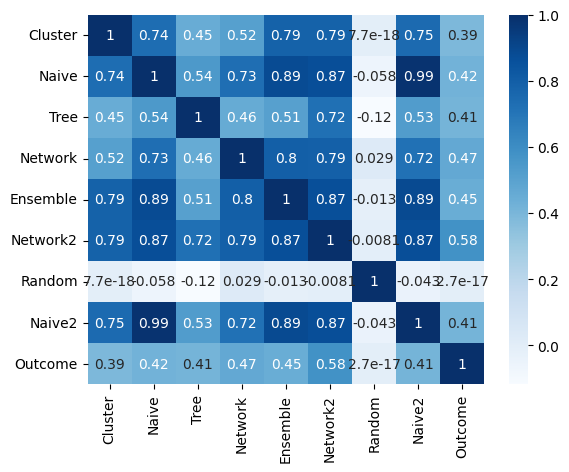

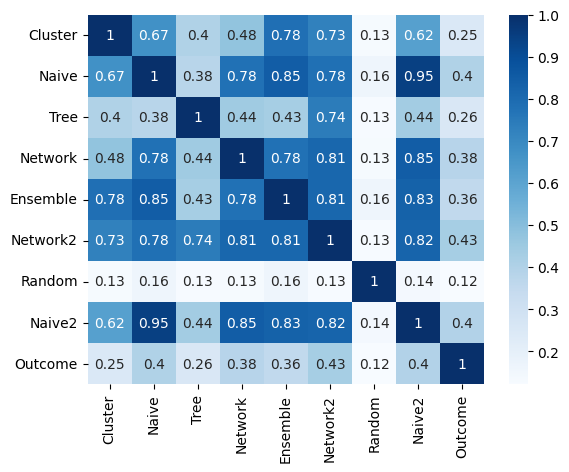

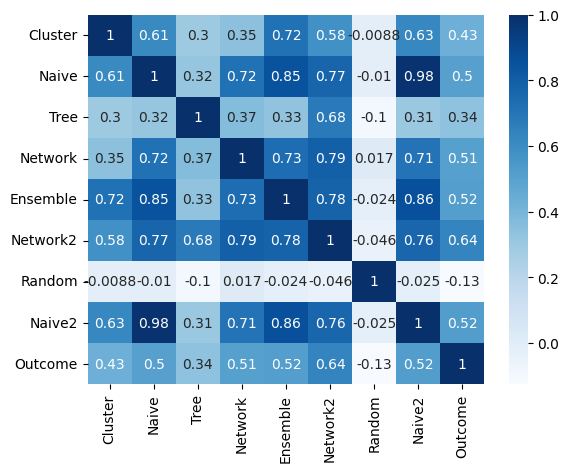

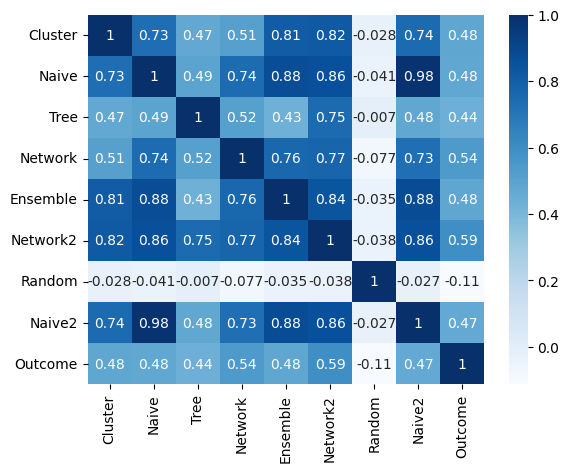

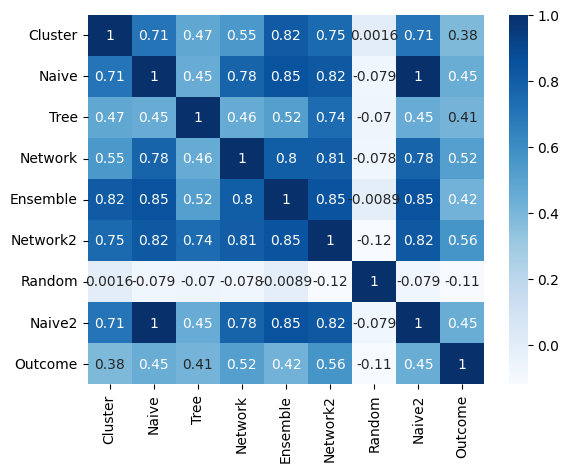

In [ ]:
print(f.value)
scores = np.array([[np.round(np.mean(acc_c)*100,3)],
                           [np.round(np.mean(acc_n)*100,3)],
                           [np.round(np.mean(acc_t)*100,3)],
                           [np.round(np.mean(nn_acc)*100,3)],
                           [np.round(ensemble_acc*100,3)],
                           [np.round(np.mean(nn_acc_2)*100,3)],
                           [np.round(np.mean(acc_n_2)*100,3)]])
tot_rnd = []
for i in range(k):
    rnd = []
    for out in y_test[i]:
        rnd.append(1 if random.randint(0,1) == out else 0)
    tot_rnd.append(np.mean(rnd))
scores = [s for s in scores]
scores.append(np.array([np.mean(tot_rnd)]))
scores = np.array(scores)
performers = pd.DataFrame(scores.T, columns=['Cluster', 'Naive', 'Tree', 'Network1', 'Ensemble', 
                                                                'Network2', 'Naive2', 'Random'])
display(performers)
for i in range(k):
    rnd = []
    for out in y_test[i]:
        rnd.append(1 if random.randint(0,1) == out else 0)
    temp_df = decision_df_test[i].copy().assign(Network2=nn_test_pred_list_2[i])
    temp_df = temp_df.assign(Random=rnd)
    temp_df = temp_df.assign(Naive2=naive_preds_2[i][1])
    temp_df = temp_df.drop(columns=colnames)
    temp_df = temp_df.assign(Outcome=y_test[i])
    sns.heatmap(temp_df.corr(), cmap='Blues', annot=True)
    plt.show()